In [1]:
import asyncio
import time

from math import nan, cos

import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.centroids import centroid_sources
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg

from plotimg import plot_images
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from lvmagp.focus.curvefit import fit_hyperbola

from IPython.display import display, clear_output



In [2]:
from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()
await lvm.sci.km.start()
await lvm.sci.km.status()

await lvm.sci.agc.start()


[[ 1.31114624 -0.40621076]
 [ 1.75813883 -0.23628508]
 [ 1.29130988 -0.18487601]
 [ 1.18762615  1.03742581]]
[[ 1.32140362 -0.40112914]
 [ 1.77623371 -0.25620925]
 [ 1.27142706 -0.18578922]
 [ 1.04760934  0.35790596]
 [ 1.40877614  1.37994594]]

median centroid diff [ 1.31114624 -0.18578922]
offset radec diff [0.18244562 1.2568162 ]


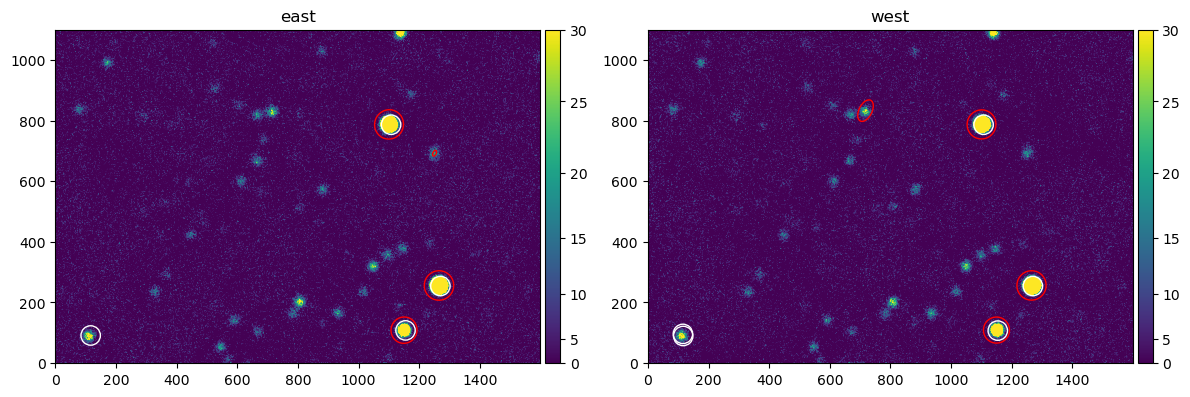

CancelledError: 

In [14]:

#%matplotlib widget
%matplotlib inline
#%matplotlib notebook

deblend_nthresh = 1.4

#source_detection = SepSourceDetection(threshold= 3.0, minarea=14.0, deblend_nthresh=deblend_nthresh)
#source_detection = SepSourceDetection(threshold= 3.0, deblend_nthresh=deblend_nthresh)
source_detection = SepSourceDetection()


async def expose(time):
    filenames = (await lvm.sci.agc.expose(time)).flatten().unpack("*.filename") 
    return [Image.from_file(f) for f in filenames]


def filter(image):
        image.data = median_filter(image.data, size=2)
        
        # photutils.background
#        bkg_estimator = MedianBackground()
#        bkg = Background2D(image.data.astype(float), (50, 50), filter_size=(3, 3),
#                           bkg_estimator=bkg_estimator)
#        bkg_median = np.median(bkg.background)
#        bkg_std = np.std(bkg.background)
#        image.data = image.data.astype(float) - bkg.background

        # sep.background
        bkg = sep.Background(image.data.astype(float))
        bkg_median = np.median(bkg)
        bkg_std = np.std(bkg_median)
        image.data = image.data.astype(float) - bkg
#        print(f"median {bkg_median}, std {bkg_std}")

        return image
    
async def detect(image):
        image = await source_detection(image)
#        image.catalog.sort("fwhm")
#        image.catalog = img_sep.catalog[img_sep.catalog["peak"] > bkg_median*2]
#        image.catalog = img_sep.catalog[img_sep.catalog["ellipticity"] < 0.35]
#        image.catalog = image.catalog[image.catalog["fwhm"] > 8]
        image.catalog = image.catalog[image.catalog["peak"] > 50]
        image.catalog = image.catalog[image.catalog["peak"] < 50000]
        image.catalog.sort("peak")
        image.catalog.reverse()
        return image
    
max_sources=4
search_boxsize=21

async def centroid(image, sources=None, centroid_func=centroid_com):
        if sources is None:
           sources = np.array([image.catalog['x'], image.catalog['y']])
#        print(sources)
        x, y = centroid_sources(image.data, sources[0], sources[1], box_size=search_boxsize,
                        centroid_func=centroid_func)
        image.centroid = np.array([x, y])
        
        
#        plt.figure(figsize=(8, 4))
#        plt.imshow(image.data, origin='lower', interpolation='nearest')
#        plt.scatter(x, y, marker='+', s=40, color='red')
#        plt.tight_layout()
        
        return image

    
exp_time = 5.0
column = "fwhm"

ref_images = await expose(exp_time)

for idx, img in enumerate(ref_images):
    ref_images[idx] = filter(ref_images[idx])
    ref_images[idx] = await detect(ref_images[idx])
    await centroid(ref_images[idx])
#    print(ref_images[idx].centroid)

    
plot_images(ref_images, cat_max=max_sources, cat_rest=True, figsize=(12, 10))

import matplotlib.pyplot as plt
#await asyncio.sleep(3.0)

guide_on = False

while True:
    await lvm.sci.pwi.status()
    await lvm.sci.km.status()

    images = await expose(exp_time)

    clear_output(wait=True)

    diff_centroid = [None] * len(images)
    for idx, img in enumerate(images):
        images[idx] = filter(images[idx])
        images[idx] = await detect(images[idx])
        await centroid(images[idx], sources=ref_images[idx].centroid)
        diff_centroid[idx] = (ref_images[idx].centroid - images[idx].centroid).transpose()
        print(diff_centroid[idx])

    cen_diff =  np.median(np.concatenate([diff_centroid[idx] for idx in range(len(images))]), axis=0)
    print(f"\nmedian centroid diff {cen_diff}")

    offset = np.array([cen_diff[1], cen_diff[0]])
    offset *= [images[0].header['BINX'], images[0].header['BINY']]
    offset *= [images[0].header['PIXELSC'], images[0].header['PIXELSC']]
    offset /= [cos(np.deg2rad(images[0].header['DEC'])), 1.0]
    offset *= [-0.95, 0.95]
    print(f"offset radec diff {offset}")
    if guide_on:
        if (abs(offset) > [0.5, 0.5]).any():
            print(f"correcting {offset}")
            await lvm.sci.pwi.offset(ra_add_arcsec = offset[0], 
                                     dec_add_arcsec = offset[1])

#    plot_images(images, cat_max=max_sources, cat_rest=True, cat_extra=[rf.catalog for rf in ref_images], figsize=(12,10))
    plot_images(images, cat_max=max_sources, cat_rest=True, figsize=(12,10))
    await asyncio.sleep(5.0)
